In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm, trange
from algo import AdaFair, AdaBoost, SMOTEBoost, SMOTEBoostProtected, AdaFairCorrect, RUSBoost, CatBoostReweight
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from utils import get_dataset
from metrics import calculate_metrics

from IPython.display import clear_output

In [2]:
import os

def plot_metrics(ax, metrics, dataset):
    metric_names = metrics[0][dataset, algorithms[0].__name__].keys()
    x = np.arange(len(metric_names))
    width = 0.11  # the width of the bars
    ax.yaxis.grid()
    for i, algo in enumerate(algorithms):
        algo_name = algo.__name__
        measurement = []
        std = []
        for m in metric_names:
            values = [metrics[i][dataset, algo_name][m] for i in range(len(metrics))]
            measurement.append(np.mean(values))
            std.append(np.std(values))
        if algo_name == "LogisticRegression" or algo_name == "RandomForestClassifier":
            rects = ax.bar(x + width * i, measurement, width, label="SMOTE + " + algo_name)
            ax.errorbar(x + width * i, measurement, yerr=std, color='black', fmt='none')
        elif algo_name == "CatBoostReweight":
            rects = ax.bar(x + width * i, measurement, width, label="AttentiveGradientBoosting")
            ax.errorbar(x + width * i, measurement, yerr=std, color='black', fmt='none')
        else:
            rects = ax.bar(x + width * i, measurement, width, label=algo_name)
            ax.errorbar(x + width * i, measurement, yerr=std, color='black', fmt='none')
    ax.set_ylim([0, 1])
    ax.legend(loc='lower right')
    ax.set_xticks(x + width * (len(algorithms) - 1) / 2, metric_names, rotation=30,
                  rotation_mode="anchor", horizontalalignment='right', verticalalignment='top')

Iteration 11


  0%|          | 0/4 [00:00<?, ?it/s]

Dataset adult
Train size: (36631, 107), Test size: (12211, 107)
Positive ratio (train): 0.239, Positive ratio (test): 0.239
Protected ratio (train): 0.332, Protected ratio (test): 0.332


  0%|          | 0/7 [00:00<?, ?it/s]


Dataset bank
Train size: (33908, 51), Test size: (11303, 51)
Positive ratio (train): 0.117, Positive ratio (test): 0.117
Protected ratio (train): 0.602, Protected ratio (test): 0.602


  0%|          | 0/7 [00:00<?, ?it/s]


Dataset compass
Train size: (4629, 11), Test size: (1543, 11)
Positive ratio (train): 0.455, Positive ratio (test): 0.455
Protected ratio (train): 0.190, Protected ratio (test): 0.191


  0%|          | 0/7 [00:00<?, ?it/s]


Dataset kdd
Train size: (224463, 409), Test size: (74822, 409)
Positive ratio (train): 0.062, Positive ratio (test): 0.062
Protected ratio (train): 0.520, Protected ratio (test): 0.520


  0%|          | 0/7 [00:00<?, ?it/s]


test metrics:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


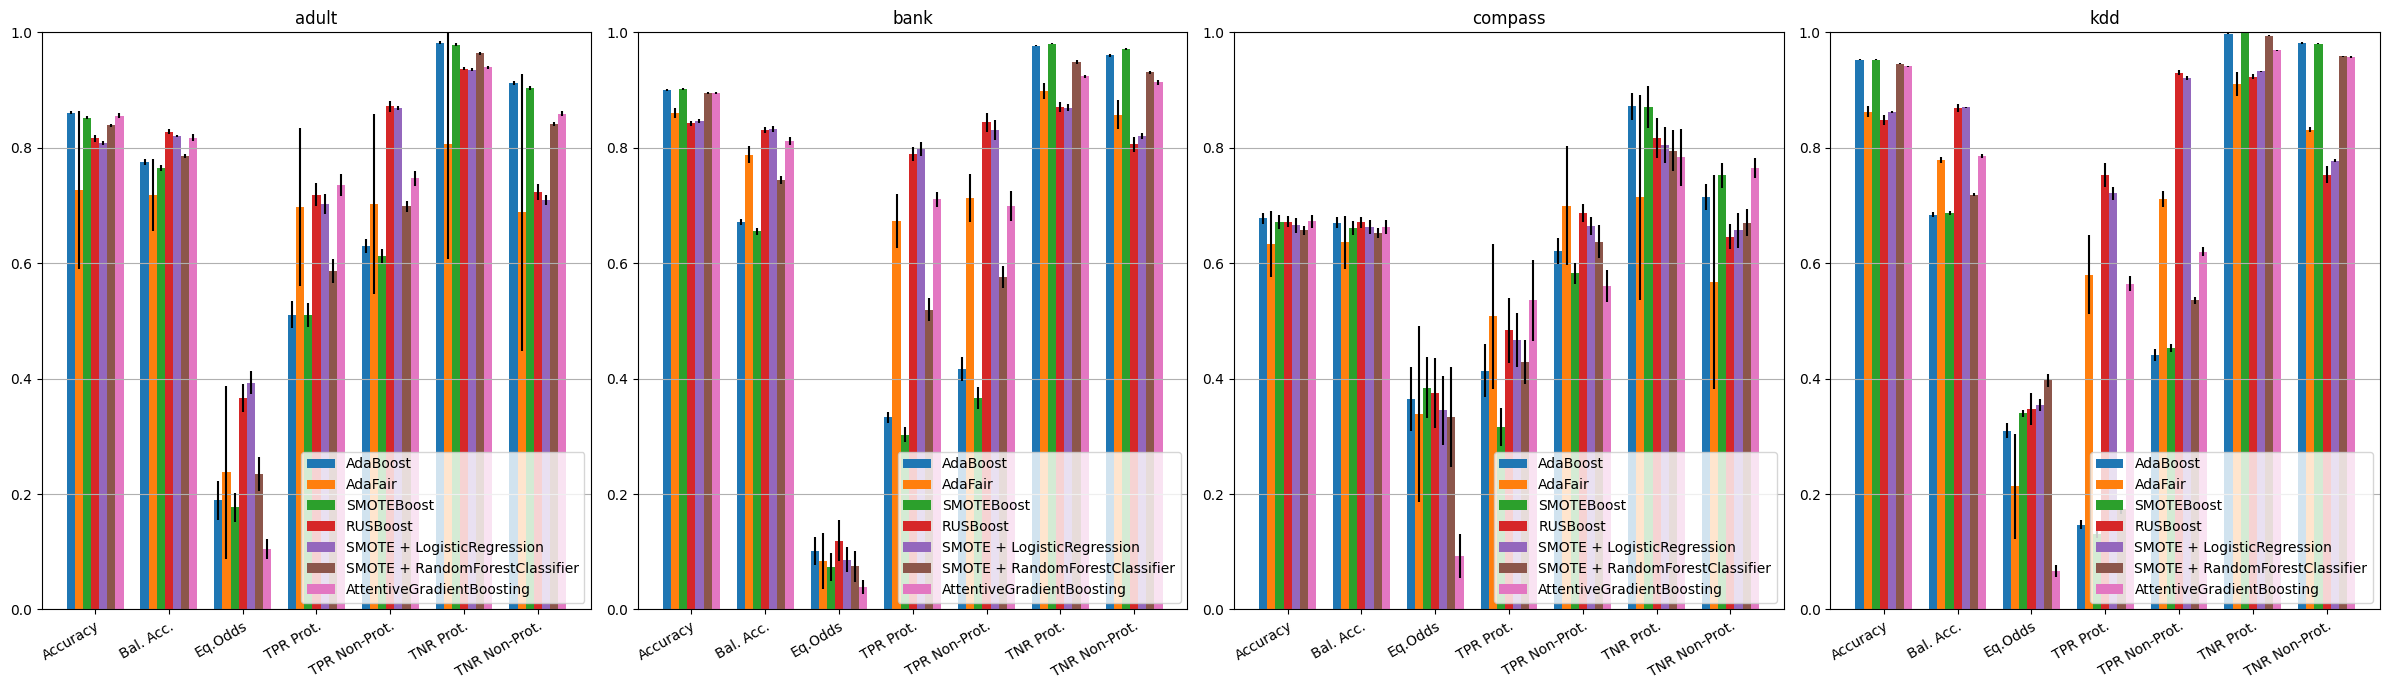

train metrics:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


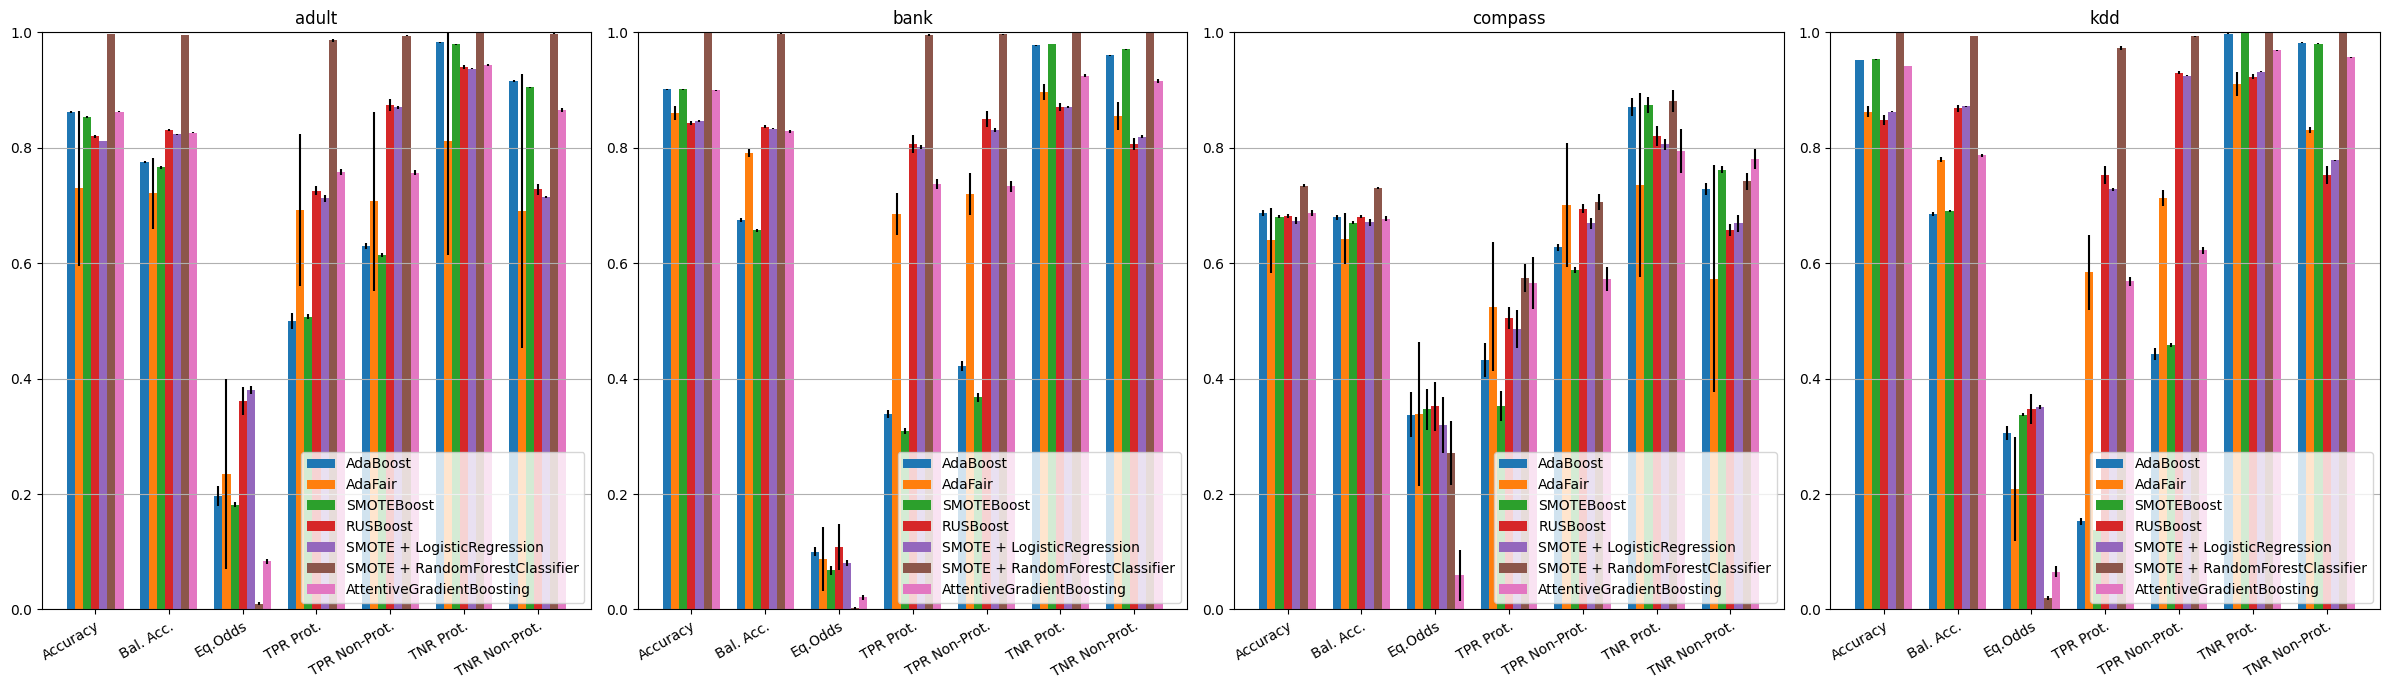

CPU times: user 4h 3min 55s, sys: 7min 41s, total: 4h 11min 37s
Wall time: 2h 21min 40s


In [3]:
%%time

dataset_list = [
    'adult',
    'bank',
    'compass',
    'kdd',
]
algorithms = [
    AdaBoost,
    AdaFair,
    SMOTEBoost,
    RUSBoost,
    LogisticRegression,
    RandomForestClassifier,
    CatBoostReweight
]
train_metrics, test_metrics = [], []
ITER_COUNT = 10

seed = 0
while seed < ITER_COUNT:
    try:
        clear_output()

        train_metrics.append({})
        test_metrics.append({})

        print(f'Iteration {seed}')

        for dataset in tqdm(dataset_list):
            X_train, y_train, is_protected_train, X_test, y_test, is_protected_test = get_dataset(dataset, test_size=0.25, random_state=seed)

            print(f'Dataset {dataset}')
            print(f'Train size: {X_train.shape}, Test size: {X_test.shape}')
            print(f'Positive ratio (train): {y_train.mean():.3f}, Positive ratio (test): {y_test.mean():.3f}')
            print(f'Protected ratio (train): {is_protected_train.mean():.3f}, Protected ratio (test): {is_protected_test.mean():.3f}')

            for model_class in tqdm(algorithms, position=1, leave=False):
                if model_class.__name__ == 'AdaFair' and (dataset == 'compass' or dataset == 'kdd'):
                    model = model_class(n_estimators=50, u_weight=1)
                    model.fit(X_train, y_train, is_protected_train)
                elif model_class.__name__ == "LogisticRegression":
                    sm = SMOTE(random_state=42)
                    X_res, y_res = sm.fit_resample(X_train, y_train)

                    model = model_class(class_weight="balanced")
                    model.fit(X_res, y_res)
                elif model_class.__name__ == "RandomForestClassifier":
                    sm = SMOTE(random_state=42)
                    X_res, y_res = sm.fit_resample(X_train, y_train)

                    model = model_class(n_estimators=20, class_weight="balanced")
                    model.fit(X_res, y_res)
                elif model_class.__name__ == "CatBoostReweight":
                    n_iter = {
                        'adult': 100,
                        'bank': 200,
                        'compass': 1000,
                        'kdd': 30
                    }
                    model = model_class(n_iter=n_iter[dataset], cb_trees=1, C=0.5, eps=0.01)
                    y_train_pred = model.fit(X_train, y_train, is_protected_train)
                else:
                    model = model_class()
                    model.fit(X_train, y_train, is_protected_train)

                if model_class.__name__ != "CatBoostReweight":
                    y_train_pred = model.predict(X_train)
                y_test_pred = model.predict(X_test)

                train_metrics[-1][dataset, model_class.__name__] = calculate_metrics(y_train, y_train_pred, is_protected_train)
                test_metrics[-1][dataset, model_class.__name__] = calculate_metrics(y_test, y_test_pred, is_protected_test)

            print()

        for metrics, name in [(test_metrics, 'test'), (train_metrics, 'train')]:
            _, axes = plt.subplots(1, len(dataset_list), figsize=(24, 7))
            if len(dataset_list) == 1:
                axes = [axes]
            print(name, 'metrics:')
            for dataset, ax in zip(dataset_list, axes):
                plot_metrics(ax, metrics, dataset)
                ax.set_title(dataset)
            plt.tight_layout()
            if not os.path.exists('plots'):
                os.mkdir('plots')
            plt.savefig(f'plots/{name}.png', dpi=150)
            plt.savefig(f'plots/{name}.eps')
            plt.show()
        seed += 1
    except:
        train_metrics = train_metrics[:-1]
        test_metrics = test_metrics[:-1]
        ITER_COUNT += 1
        seed += 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


test metrics:


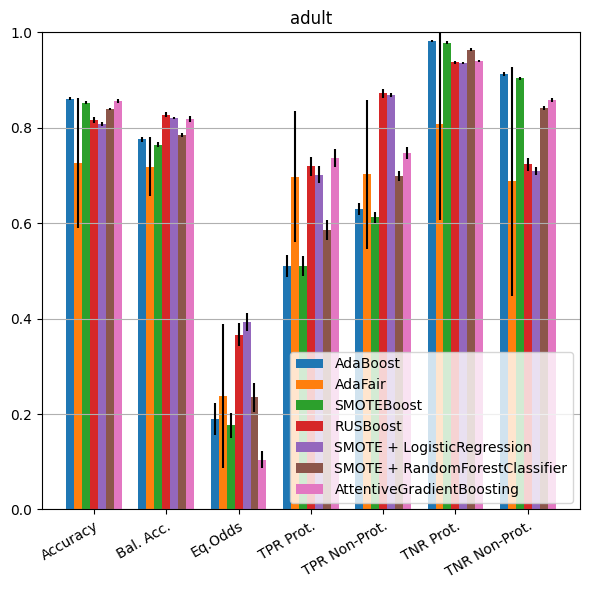

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


train metrics:


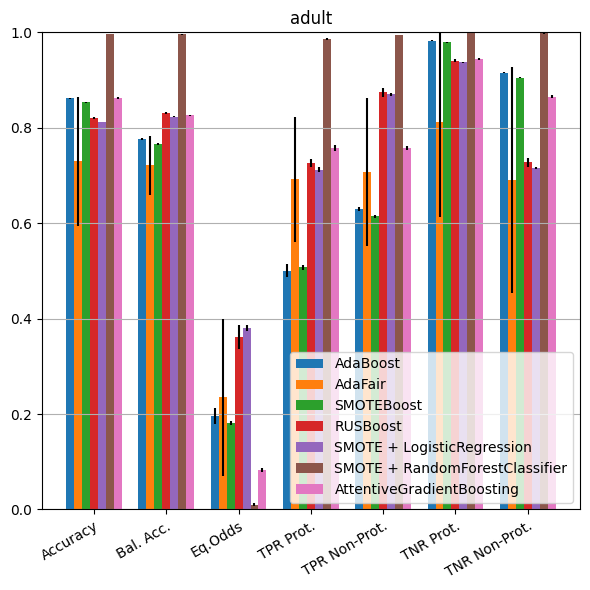

test metrics:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


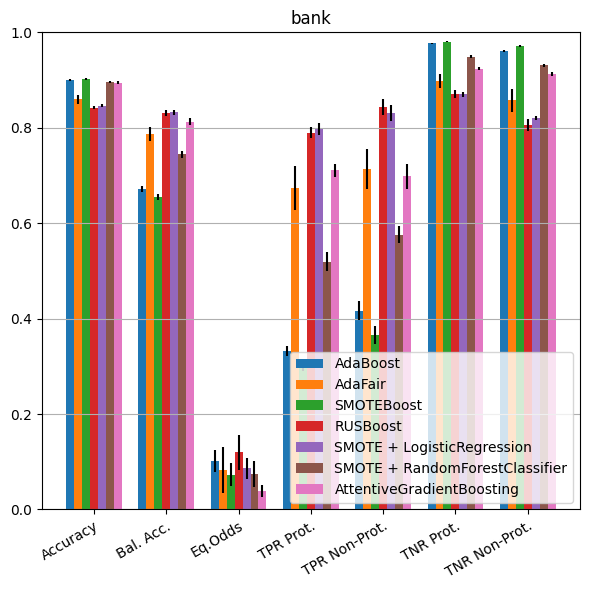

train metrics:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


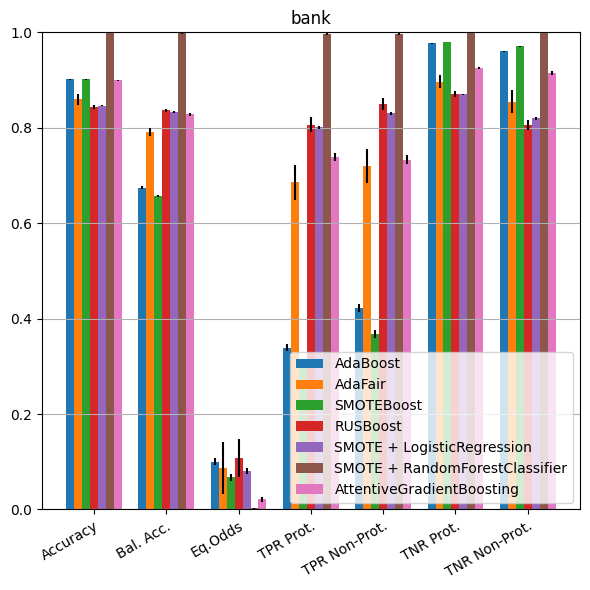

test metrics:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


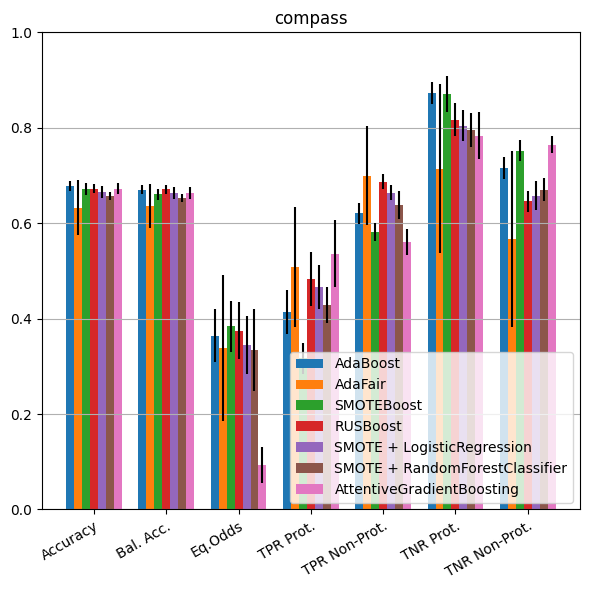

train metrics:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


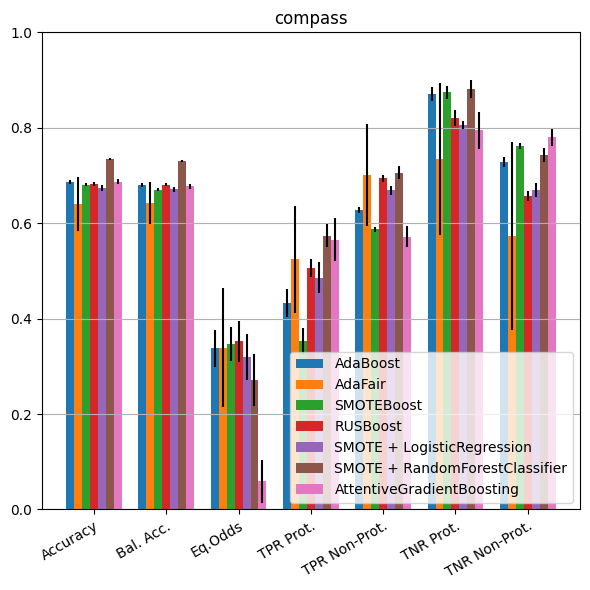

test metrics:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


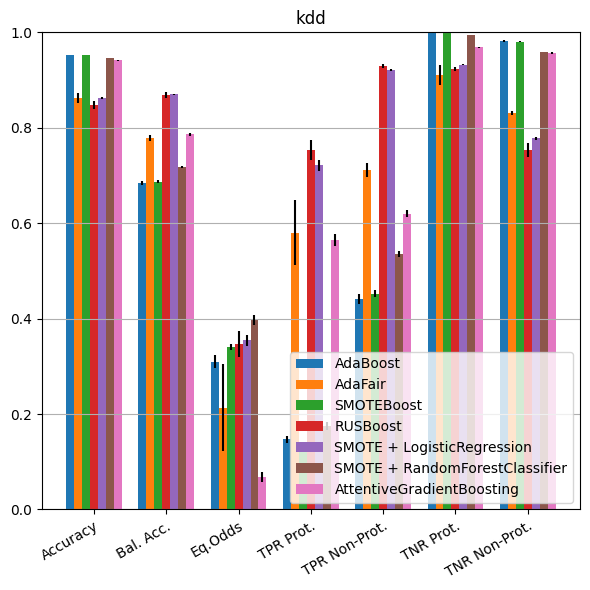

train metrics:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


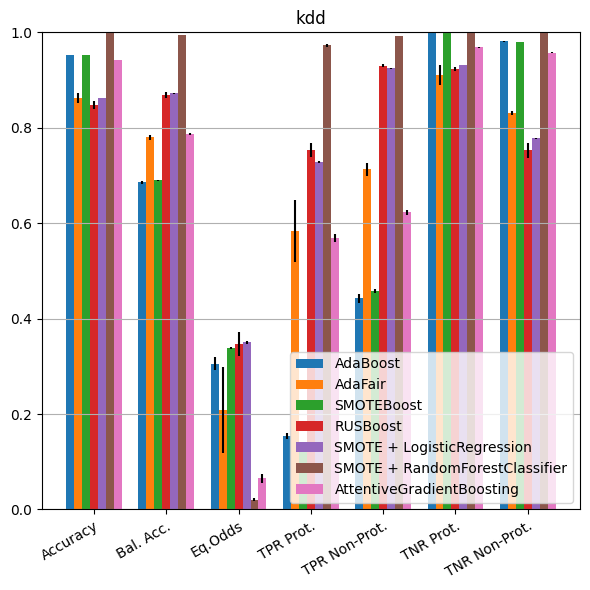

In [8]:
for dataset in dataset_list:
    current_dataset_list = [dataset]
    for metrics, name in [(test_metrics, 'test'), (train_metrics, 'train')]:
        _, axes = plt.subplots(1, len(current_dataset_list), figsize=(6, 6))
        if len(current_dataset_list) == 1:
            axes = [axes]
        print(name, 'metrics:')
        for dataset, ax in zip(current_dataset_list, axes):
            plot_metrics(ax, metrics, dataset)
            ax.set_title(dataset)
        plt.tight_layout()
        if not os.path.exists('plots'):
            os.mkdir('plots')
        plt.savefig(f'plots/{name}_{dataset}.png', dpi=150)
        plt.savefig(f'plots/{name}_{dataset}.eps')
        plt.show()